# 1.读取raw_data

In [3]:
import pandas as pd
import numpy as np
# 读取10个csv并合并
for num in range(1, 5):
    file_path = f'发动机试验数据/高频信号/1800-57%-正常工况/1800-57%-{num}-Z1.csv'
    data = pd.read_csv(file_path)
    data = data.drop(columns=[data.columns[-1]])
    samples = data.iloc[:, 1:].values
    if num == 1:
        positive_samples = samples
    else:
        positive_samples = np.concatenate((positive_samples, samples), axis=1)
print("样本集的形状:", positive_samples.shape)
print("前几行的样本:")
print(positive_samples[:5])

for num in range(1, 5):
    file_path = f'发动机试验数据/高频信号/1800-57%-断缸/1800-57%-{num}-Z1.csv'
    data = pd.read_csv(file_path)
    data = data.drop(columns=[data.columns[-1]])
    n_samples = data.iloc[:, 1:].values
    if num == 1:
        negetive_samples = n_samples
    else:
        negetive_samples = np.concatenate((negetive_samples, n_samples), axis=1)
print("样本集的形状:", negetive_samples.shape)
print("前几行的样本:")
print(negetive_samples[:5])


样本集的形状: (7200, 2000)
前几行的样本:
[[3.34 2.48 3.15 ... 0.58 2.17 2.66]
 [3.4  2.72 3.15 ... 1.56 2.91 3.03]
 [3.15 2.66 3.09 ... 1.44 3.77 3.03]
 [3.64 2.48 2.72 ... 1.32 3.89 2.48]
 [3.52 2.42 2.6  ... 1.5  3.77 2.23]]
样本集的形状: (7200, 2000)
前几行的样本:
[[3.95 3.03 5.42 ... 3.03 4.38 4.62]
 [3.46 3.09 5.79 ... 4.56 2.97 4.5 ]
 [4.26 3.83 6.03 ... 4.32 4.81 4.93]
 [3.89 3.89 5.11 ... 3.28 5.05 4.69]
 [3.46 3.4  4.56 ... 3.34 4.69 3.64]]


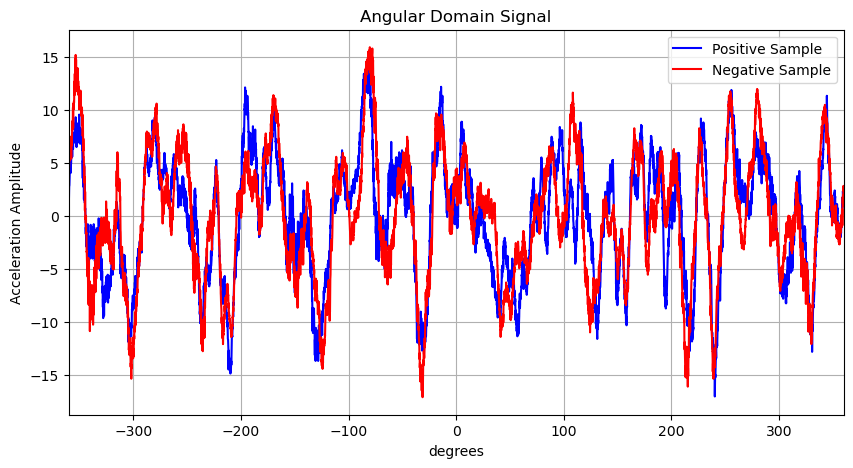

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 随机抽取一个样本
degree_values = data['Degree'].values
random_index = np.random.randint(0, negetive_samples.shape[1])
random_sample_pos = positive_samples[:, random_index]
random_sample_neg = negetive_samples[:, random_index]


# 绘制信号图
plt.figure(figsize=(10, 5))
plt.plot(degree_values, random_sample_pos, color = 'blue', label='Positive Sample')
plt.plot(degree_values, random_sample_neg, color = 'red', label='Negative Sample')
plt.title('Angular Domain Signal')
plt.xlabel('degrees')
plt.ylabel('Acceleration Amplitude')
plt.xlim(-360, 360)
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GATConv,  BatchNorm,  global_mean_pool, GCNConv# noqa

from dataprocess.dataset import read_data, create_graph_data

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # 聚合每个图的节点输出
        return F.log_softmax(x, dim=1)
    
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 8)
        self.conv2 = GCNConv(8, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # 第一层图卷积
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # # 第二层图卷积
        x = self.conv2(x, edge_index)
        
        # 池化并生成最终输出
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

In [26]:
import numpy as np
import torch
from torch_geometric.data import Data

def construct_graph(sample, label, num_nodes=10):
    
    nodes = []
    for i in range(num_nodes):
        node_features = sample[i * (7200//num_nodes): (i + 1) * 7200//num_nodes]
        nodes.append(node_features)
    
    # 构建边的索引
    edge_index = torch.tensor([np.arange(num_nodes-1), np.arange(1,num_nodes)], dtype=torch.long)
    
    # 将节点特征、边索引和标签转为PyTorch Geometric的数据对象
    graph_data = Data(x=torch.tensor(np.array(nodes), dtype=torch.float), 
                      edge_index=edge_index, 
                      y=torch.tensor([label], dtype=torch.long))
    
    return graph_data

# 构建正样本集的图数据集，标签为0
positive_graphs = []
for i in range(positive_samples.shape[1]):
    sample = positive_samples[:, i]
    graph_data = construct_graph(sample, label=0, num_nodes=5)
    positive_graphs.append(graph_data)

# 构建负样本集的图数据集，标签为1
negative_graphs = []
for i in range(negetive_samples.shape[1]):
    sample = negetive_samples[:, i]
    graph_data = construct_graph(sample, label=1, num_nodes=5)
    negative_graphs.append(graph_data)

print("正样本集的图数据集大小:", len(positive_graphs))
print("负样本集的图数据集大小:", len(negative_graphs))
print("正样本集的第一个图数据:" , positive_graphs[0])
# 合并正样本和负样本的图数据集
all_graphs = positive_graphs[:1000] + negative_graphs[:1000]
for data in all_graphs:
    print(data.x)
    print(data.edge_index)
    print(data.y)
    break

正样本集的图数据集大小: 2000
负样本集的图数据集大小: 2000
正样本集的第一个图数据: Data(x=[5, 1440], edge_index=[2, 4], y=[1])
tensor([[ 3.3400,  3.4000,  3.1500,  ..., -9.1600, -8.3700, -8.9200],
        [-9.4700, -9.4100, -9.3500,  ..., -2.7900, -4.2000, -4.4500],
        [-3.6500, -3.1600, -3.2800,  ...,  0.5200,  1.1300,  1.6800],
        [ 1.5000,  1.3200,  1.2500,  ..., -5.8500, -4.7500, -5.3600],
        [-6.7100, -6.4700, -5.8500,  ...,  2.3600,  1.9300,  2.2300]])
tensor([[0, 1, 2, 3],
        [1, 2, 3, 4]])
tensor([0])


In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import random

# 假设 all_graphs 包含了构建的图数据集
# 将图数据集分为训练集和测试集
batch_size = 32
random.shuffle(all_graphs)
dataset = all_graphs
train_dataset = dataset[:int(0.01 * len(dataset))]
test_dataset = dataset[int(0.5 * len(dataset)):]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 确定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 假设 GAT 模型的输入维度是节点特征维度 (1440)，输出维度根据具体任务设置
model = GCN(in_channels=1440, out_channels=2).to(device)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.view(-1))  # 交叉熵损失
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)
# for data in train_loader:
#     print("Node features shape:", data.x.shape)
#     print("Edge index shape:", data.edge_index.shape)
#     print("Labels (y):", data.y)
#     print("Batch size:", data.batch.shape if hasattr(data, 'batch') else "No batch")
#     break

# 训练和评估
for epoch in range(1, 20):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
# 随机选取三个测试集中的样本输出预测值和实际标签
def predict_random_samples(test_loader, num_samples=3):
    model.eval()
    selected_samples = random.sample(list(test_loader.dataset), num_samples)
    
    for i, data in enumerate(selected_samples):
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        print(f"Sample {i+1}:")
        print(f"Predicted label: {pred.item()}, True label: {data.y.item()}")

# 调用函数进行预测
predict_random_samples(test_loader, num_samples=10)


Epoch: 001, Loss: 0.8370, Train Acc: 0.6000, Test Acc: 0.6680
Epoch: 002, Loss: 0.5603, Train Acc: 0.9500, Test Acc: 0.9190
Epoch: 003, Loss: 0.5772, Train Acc: 1.0000, Test Acc: 0.9670
Epoch: 004, Loss: 0.2575, Train Acc: 0.9500, Test Acc: 0.8010
Epoch: 005, Loss: 0.3799, Train Acc: 0.9500, Test Acc: 0.8650
Epoch: 006, Loss: 0.2253, Train Acc: 0.9500, Test Acc: 0.9560
Epoch: 007, Loss: 0.1193, Train Acc: 0.9500, Test Acc: 0.9900
Epoch: 008, Loss: 0.1762, Train Acc: 1.0000, Test Acc: 0.9970
Epoch: 009, Loss: 0.2286, Train Acc: 1.0000, Test Acc: 0.9990
Epoch: 010, Loss: 0.1248, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 011, Loss: 0.1146, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 012, Loss: 0.1347, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 013, Loss: 0.0545, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 014, Loss: 0.1043, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 015, Loss: 0.1105, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 016, Loss: 0.0410, Train Acc: 1.0000, Test Acc: 1.0000
Epoch: 0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 数据准备
positive_samples = positive_samples.T  # 转置数据，使每行是一个样本
negative_samples = negetive_samples.T  # 转置数据，使每行是一个样本

# 创建标签
positive_labels = np.zeros(positive_samples.shape[0])  # 标签0表示正常工况
negative_labels = np.ones(negative_samples.shape[0])   # 标签1表示断缸

# 合并样本和标签
X = np.concatenate((positive_samples, negative_samples), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 调整形状为 LSTM 输入格式
X_train = X_train.reshape(X_train.shape[0], -1, 1)
X_test = X_test.reshape(X_test.shape[0], -1, 1)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # 取最后一个时间步的输出
        out = self.fc(out)
        return out

# 模型参数
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes).to(device)

In [5]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train.to(device))
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

: 

In [145]:
# 测试模型
model.eval()
with torch.no_grad():
    outputs = model(X_test.to(device))
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test.to(device)).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')